In [1]:
from pathlib import Path
from typing import List, Tuple, Dict, Union

from cities.utils.data_grabber import DataGrabber
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import pickle
import os
import sys

current_dir =  os.getcwd()

grandparent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, grandparent_dir)

In [2]:
data = DataGrabber()
data.get_features_wide(["gdp", "population", "unemployment_rate", "spending_HHS", "ethnic_composition"])
data.get_features_std_wide(["gdp", "population", "unemployment_rate", "spending_HHS", "ethnic_composition"])
data.get_features_long(["gdp", "population", "spending_HHS", "ethnic_composition"])


gdp = data.wide
gdp = gdp.get("gdp")
gdp_long = data.long['gdp']
display(gdp_long.head())

spending_HHS_long = data.long['spending_HHS']

display(spending_HHS_long.head())

population= data.wide
population = population.get("population")

spending_HHS= data.wide
spending_HHS = spending_HHS.get("spending_HHS")


ethnic_composition= data.wide
ethnic_composition = ethnic_composition.get("ethnic_composition")

,GeoFIPS,GeoName,Year,Value
0,1001,"Autauga, AL",2001,59.839
1,1003,"Baldwin, AL",2001,73.853
2,1005,"Barbour, AL",2001,113.864
3,1007,"Bibb, AL",2001,80.443
4,1009,"Blount, AL",2001,92.104


,GeoFIPS,GeoName,Year,total_obligated_amount
0,1001,"Autauga, AL",2018,0.0
1,1003,"Baldwin, AL",2010,49158971.0
2,1003,"Baldwin, AL",2011,23130080.0
3,1003,"Baldwin, AL",2012,23130080.0
4,1003,"Baldwin, AL",2013,23130080.0


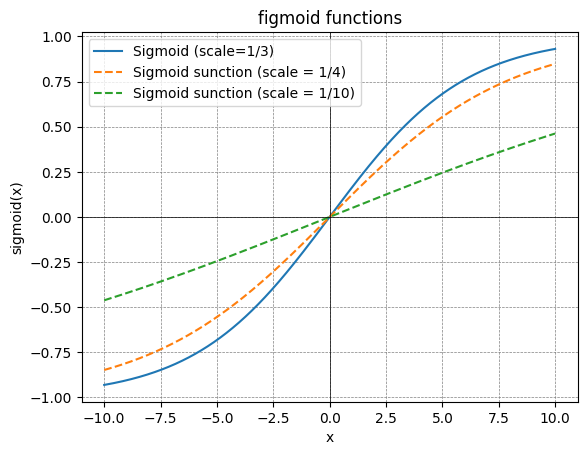

In [3]:
# just to get intuitions

def sigmoid(x, scale=1 / 3):
    return 2 / (1 + np.exp(-x * scale)) - 1

x_values = np.linspace(-10, 10, 1000)
y_values = sigmoid(x_values)
y_4_values = sigmoid(x_values, scale=1 / 4)
y_10_values = sigmoid(x_values, scale=1 / 10)

plt.plot(x_values, y_values, label='Sigmoid (scale=1/3)')
plt.plot(x_values, y_4_values, label='Sigmoid sunction (scale = 1/4)', linestyle='dashed')
plt.plot(x_values, y_10_values, label='Sigmoid sunction (scale = 1/10)', linestyle='dashed')

plt.title('figmoid functions')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()


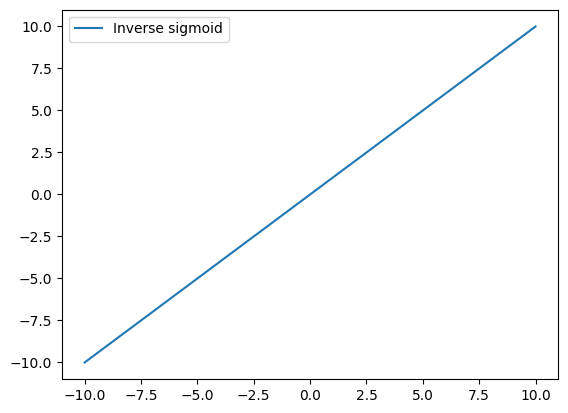

maximum_difference: 8.881784197001252e-15


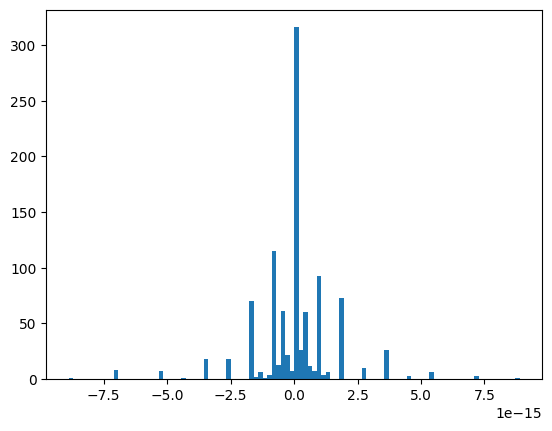

In [4]:
# R: sigmoid inversion works for this range 
def inverse_sigmoid(y, scale=1 / 3):
    return -np.log((2 / (y + 1)) - 1) / scale

x_values = np.linspace(-10, 10, 1000)

y = sigmoid(x_values)

x_back = inverse_sigmoid(y)

assert np.allclose(x_values, x_back)

# exact equality fails
#assert np.array_equal(x_values, x_back)

plt.plot(x_values, x_back, label='Inverse sigmoid')
plt.legend()
plt.show()

difs = x_values - x_back

print("maximum_difference:", max(difs))
plt.hist(difs, bins=100)
plt.show()

In [5]:
# set up mock predictions table

year = [2015, 2016, 2017]
observed = [.51,.51,.51]
mean = [.5,.5,.5]
low = [0.3,.4,.45]
high = [.55,.65,.75]

mock_predictions = pd.DataFrame({'year': year, "observed": observed, 'mean': mean, 'low': low, 'high': high})

In [6]:
def revert_standardize_and_scale_scaler(transformed_values: Union[np.ndarray, List, pd.Series, float], year: int, variable_name: str) -> List:
    if not isinstance(transformed_values, np.ndarray):
        transformed_values = np.array(transformed_values)

    def inverse_sigmoid(y, scale=1 / 3):
        return -np.log((2 / (y + 1)) - 1) / scale

    dg = DataGrabber()
    dg.get_features_wide([variable_name])

    original_column = dg.wide[variable_name][str(year)].values.reshape(-1, 1)

    scaler = StandardScaler()
    scaler.fit(original_column)

    inverted_values_sigmoid = inverse_sigmoid(transformed_values)
    inverted_values = scaler.inverse_transform(inverted_values_sigmoid.reshape(-1, 1)).flatten()

    return inverted_values

    
revert_standardize_and_scale_scaler(mock_predictions.iloc[0,1:].values, 2017, 'unemployment_rate')

array([10.18039163, 10.04695225,  7.66332148, 10.73360339])

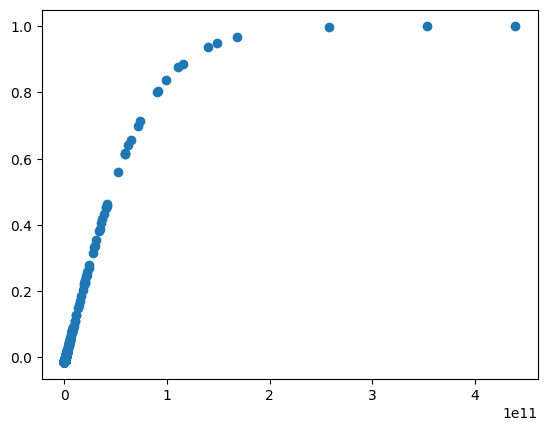

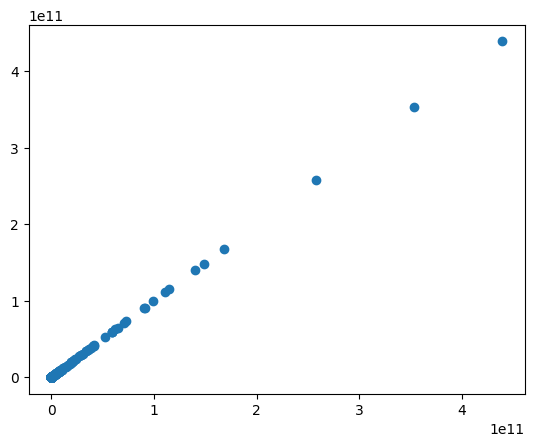

max_dif 0.0252685546875


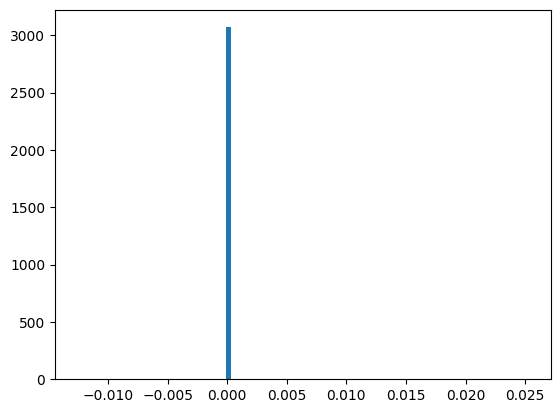

In [7]:
# testing inversion on real weird-shaped data

original = data.wide['spending_HHS']['2011'].values
transformed = data.std_wide['spending_HHS']['2011'].values

plt.scatter(original, transformed)
plt.show()

inverted = revert_standardize_and_scale_scaler(np.array(transformed), 2011, 'spending_HHS')

plt.scatter(original, inverted)
plt.show()

#assert np.allclose(original, inverted)

difs = original - inverted
print("max_dif", max(difs))
plt.hist(difs, bins=100)
plt.show()

In [8]:
# now a function that applies to a prediction frame

def revert_prediction_df(df: pd.DataFrame, variable_name: str) -> pd.DataFrame:
    df_copy = df.copy()
    
    for i in range(len(df)):
        df_copy.iloc[i, 1:] = revert_standardize_and_scale_scaler(df.iloc[i, 1:].values, df.iloc[i, 0], variable_name)
    
    return df_copy

print(mock_predictions)
print(
    revert_prediction_df(mock_predictions, 'unemployment_rate')
)

   year  observed  mean   low  high
0  2015      0.51   0.5  0.30  0.55
1  2016      0.51   0.5  0.40  0.65
2  2017      0.51   0.5  0.45  0.75
   year   observed       mean        low       high
0  2015  12.353117  12.190238   9.280722  13.028381
1  2016  11.691381  11.537282  10.094786  14.131591
2  2017  10.180392  10.046952   9.404729  14.258292


In [10]:
def log10_sigmoid_transform(data: pd.DataFrame, offset=1e-10) -> pd.DataFrame:
    """
    Applies log10 transformation followed by sigmoid transformation to float columns in a DataFrame. 
    Returns a new DataFrame.
    """
    def sigmoid(x, scale=1 / 3):
        range_0_1 = 1 / (1 + np.exp(-x * scale))
        range_minus1_1 = 2 * range_0_1 - 1
        return range_minus1_1

    # Copy all columns first
    new_data = data.copy()

    # Select float columns
    float_cols = data.select_dtypes(include=["float64"])

    # Apply log10 transformation
    log10_data = float_cols.apply(lambda x: np.log10(x + offset))

    # Apply sigmoid transformation, [-3, 3] to [-1, 1]
    sigmoid_data = sigmoid(log10_data, scale=1 / 3)

    # Update the DataFrame with transformed values
    new_data[float_cols.columns] = sigmoid_data

    return new_data


def inverse_log10_sigmoid_transform(transformed_data: pd.DataFrame, offset=1e-10) -> pd.DataFrame:
    """
    Attempts to revert the combined log10 and sigmoid transformation applied to float columns in a DataFrame.
    Returns a new DataFrame.
    """
    def inverse_sigmoid(x, scale=1 / 3):
        sigmoid_inv = np.log((x + 1) / (1 - x)) / scale
        return sigmoid_inv

    # Copy all columns first
    original_data = transformed_data.copy()

    # Select float columns
    float_cols = transformed_data.select_dtypes(include=["float64"])

    # Inverse sigmoid transformation
    inverse_sigmoid_data = inverse_sigmoid(float_cols, scale=1 / 3)

    # Inverse log10 transformation
    inverse_log10_data = 10 ** inverse_sigmoid_data - offset

    # Update the DataFrame with reverted values
    original_data[float_cols.columns] = inverse_log10_data

    return original_data



In [11]:
gdp_stand = log10_sigmoid_transform(gdp)

gdp_restored = inverse_log10_sigmoid_transform(gdp_stand)
gdp_restored

,GeoFIPS,GeoName,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",59.839,61.996,63.508,73.730,75.307,80.459,81.836,73.870,...,86.679,93.060,93.155,99.931,104.090,99.798,100.854,97.233,96.115,94.638
1,1003,"Baldwin, AL",73.853,77.273,81.570,90.523,101.402,104.553,107.840,102.635,...,99.000,104.651,106.431,110.434,115.476,118.498,125.068,131.431,131.614,144.294
2,1005,"Barbour, AL",113.864,111.853,114.628,124.473,125.004,122.611,118.397,110.695,...,103.918,113.335,106.760,103.702,101.969,100.509,101.804,102.053,98.044,99.393
3,1007,"Bibb, AL",80.443,81.527,85.124,89.317,88.782,89.597,95.308,94.745,...,102.559,99.537,97.933,94.594,95.812,96.878,96.988,104.620,109.487,107.878
4,1009,"Blount, AL",92.104,92.593,95.469,98.129,100.918,97.428,96.720,97.077,...,91.938,99.318,101.584,106.506,98.394,104.331,109.560,106.565,100.422,113.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,56037,"Sweetwater, WY",92.340,81.094,83.237,84.315,89.539,103.241,109.911,112.520,...,103.317,99.506,96.656,93.916,91.543,89.449,86.267,88.195,80.164,74.912
3070,56039,"Teton, WY",81.931,84.886,85.316,86.359,88.884,96.508,98.646,97.627,...,95.810,102.194,110.461,112.837,114.846,119.415,121.268,123.476,125.412,155.522
3071,56041,"Uinta, WY",99.906,110.550,107.053,108.929,112.808,123.552,126.916,127.784,...,106.181,96.674,94.344,95.302,94.681,93.024,89.431,86.759,77.512,76.147
3072,56043,"Washakie, WY",92.187,91.281,95.083,95.411,91.317,102.153,95.987,106.530,...,107.934,101.335,104.043,106.056,94.451,89.130,89.160,92.316,91.539,92.003


In [12]:
spending_HHS_stand = log10_sigmoid_transform(spending_HHS)

spending_HHS_restored = inverse_log10_sigmoid_transform(spending_HHS_stand)

spending_HHS_restored

,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1003,"Baldwin, AL",4.915897e+07,23130080.0,23130080.0,2.313008e+07,3.644030e+07,1.847241e+07,3.528641e+07,5.226931e+07,5.233552e+07,6.820575e+07,2.908341e+07,1.472459e+07
2,1005,"Barbour, AL",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1007,"Bibb, AL",0.000000e+00,0.0,13161891.0,6.691627e+07,6.691627e+07,8.721251e+07,8.778570e+07,1.102956e+08,2.311282e+08,3.560715e+08,3.956040e+08,3.497175e+08
4,1009,"Blount, AL",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.236365e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,56037,"Sweetwater, WY",9.662044e+06,4831022.0,9662044.0,6.629890e+06,1.109392e+07,1.555794e+07,2.658571e+07,2.422140e+07,1.340291e+07,2.680582e+07,2.680582e+07,2.710532e+07
3070,56039,"Teton, WY",1.137857e+07,5689287.0,5689287.0,5.689287e+06,1.706786e+07,4.765628e+06,1.429688e+07,1.457931e+07,1.906251e+07,2.382814e+07,3.070260e+07,1.146478e+07
3071,56041,"Uinta, WY",6.249070e+06,6054374.0,6054374.0,3.565639e+06,3.565639e+06,1.292109e+07,2.940783e+07,2.005237e+07,3.432017e+07,4.345827e+07,5.672066e+07,4.280595e+07
3072,56043,"Washakie, WY",6.430779e+07,46573884.0,28839979.0,4.386888e+07,2.118667e+07,2.301668e+07,6.093502e+07,5.552501e+07,1.010162e+08,1.494539e+08,1.629841e+08,1.116085e+08


In [13]:
def compare_restored_data(data_oryg: pd.DataFrame, data_restored: pd.DataFrame) -> None:
    

    oryg_values = data_oryg.select_dtypes(include=["float64"]).values.flatten()
    restored_values = data_restored.select_dtypes(include=["float64"]).values.flatten()

    differences = abs(oryg_values - restored_values)


    df = pd.DataFrame({'original': oryg_values, 'diff': differences})

   
    df['percentages'] = (df['diff'] / (df['original'] + 0.1)) * 100

    df = df.sort_values(by='original', ascending=True)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot for Percentage Difference
    ax1.plot(df['original'], df['percentages'], marker='o', linestyle='-')
    ax1.set_title('Percentage Difference')
    ax1.set_xlabel('Index (ordered ascending)')
    ax1.set_ylabel('Percentage Difference')

    # Plot for Absolute Difference
    ax2.plot(df['original'], df['diff'], marker='o', linestyle='-', color='orange')
    ax2.set_title('Absolute Difference')
    ax2.set_xlabel('Index (ordered ascending)')
    ax2.set_ylabel('Absolute Difference')

    total_rows = df.shape[0]
    first_05_percent = df.head(int(0.05 * total_rows))
    last_95_percent = df.tail(int(0.95 * total_rows))

    mean_first_5_percent = round(first_05_percent['percentages'].mean(), 4)
    mean_last_95_percent = round(last_95_percent['percentages'].mean(), 4)

    print(f"Mean Percentage of First 5%: {mean_first_5_percent}")
    print(f"Mean Percentage of Last 95%: {mean_last_95_percent}")

    plt.tight_layout()
    plt.show()


Mean Percentage of First 5%: 0.0
Mean Percentage of Last 95%: 0.0


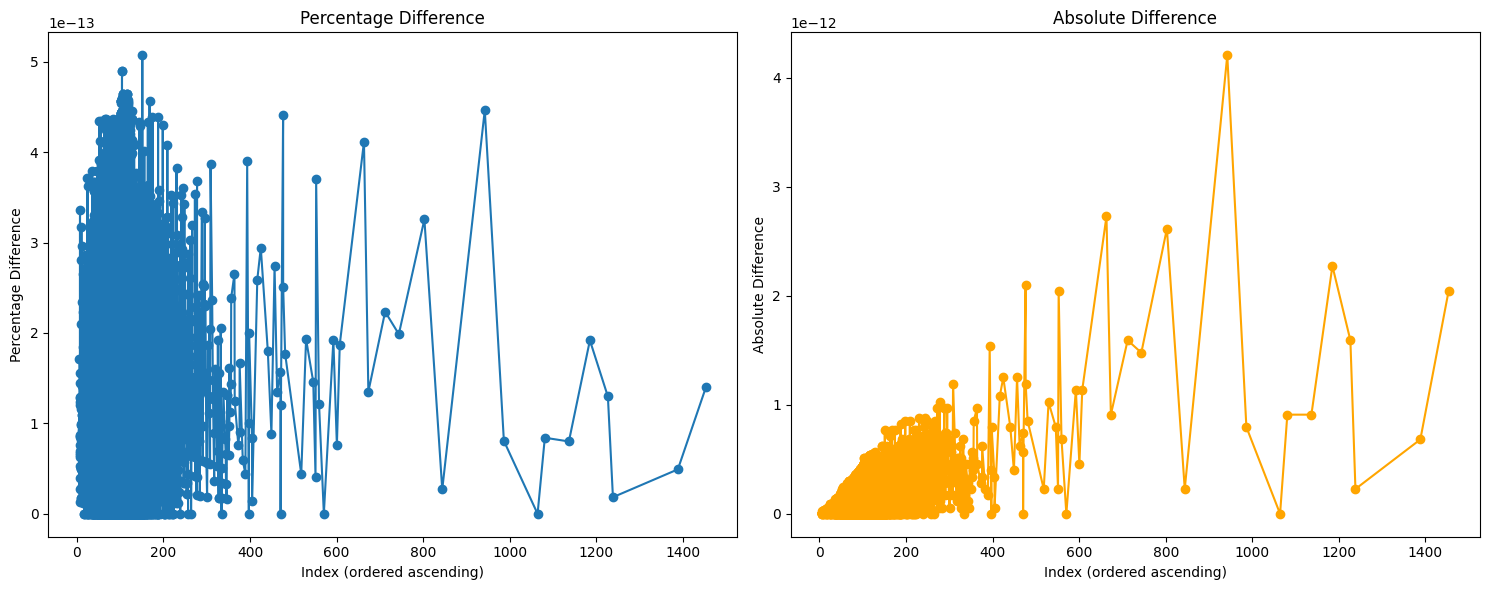

In [14]:
compare_restored_data(gdp, gdp_restored)